# Deploy best PyTorch model
In this notebook we'll use SageMaker to deploy the best model from the Optuna hyperparameter search and analyse the predictions on the validation dataset.

The tasks here include:
- Download best model from Weights and Biases
- Create tar files with required files by SageMaker and upload to S3 bucket
- Create SageMaker inference endpoint using `PyTorchModel` class
- Run predictions on endpoint

## Setup

In [162]:
%load_ext autoreload
%autoreload 2

In [161]:
import os
import shutil
import sys
import tarfile

import git
from IPython.display import IFrame
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import sagemaker
from sagemaker.pytorch import PyTorchModel
from tqdm.auto import tqdm
import torch
import wandb
import yaml

In [164]:
# Resolve repo root path and add to path
git_repo = git.Repo(".", search_parent_directories=True)
PROJECT_ROOT_PATH = git_repo.working_dir

sys.path.append(PROJECT_ROOT_PATH)

from src.utils import get_wandb_project_runs, set_sagemaker_settings, upload_model_to_s3
from src.data import extract_patient_filepaths, extract_dataset_filepaths
from src.predict import predict_segmentation_masks
from src.visualize import plot_endpoint_prediction

In [13]:
with open("./../config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
config

{'DATA_DIR': 'data',
 'DATA_ZIP_FILENAME': 'lgg-mri-segmentation.zip',
 'DUMMY_IAM_ROLE': 'arn:aws:iam::111111111111:role/service-role/AmazonSageMaker-ExecutionRole-20200101T000001',
 'KAGGLE_DATASET': 'mateuszbuda/lgg-mri-segmentation',
 'RUN_MODE': 'sagemaker',
 'S3_BUCKET_NAME': 'sagemaker-brain-mri'}

In [163]:
git_repo = git.Repo('.', search_parent_directories=True)
PROJECT_ROOT_PATH = git_repo.working_dir
DATA_ROOT_PATH = os.path.join(PROJECT_ROOT_PATH, config['DATA_DIR'])

## Download best model from Weights & Biases
### Retrieve run information

Along with the experiment configuration and metrics, the best model checkpoints were submitted to Weights and Biases during the Optuna hyperparameter search. These can be viewed on the `Artifacts` page like shown below. Note that I created a callback for Optuna so that the model was only logged to W&B if the validation score improved.

<iframe src="https://wandb.ai/robsmith155/brain-mri-segmentation/artifacts/model/model-mwk66y5o/v0" width="1200" height="1000"></iframe>

We can retrieve all the run information from a Weights and Biases project using the `wandb` API. A function based on code from W&B is provided in the `src/utils.py` module to extract this information into a Pandas DataFrame.

In [ ]:
runs_df = get_wandb_project_runs(wandb_user='robsmith155')

In [2]:
runs_df

summary  \
0    {'gradients/graph_10net.model.1.submodule.0.co...   
1    {'gradients/graph_9net.model.1.upconv.up.conv....   
2    {'train_loss_epoch': 0.7647662162780762, 'grad...   
3    {'gradients/graph_7net.model.1.submodule.1.att...   
4    {'Epoch 6 predictions (Mean val Dice score:  0...   
..                                                 ...   
112  {'Epoch 26 predictions (Mean val Dice score:  ...   
113  {'gradients/graph_3net.model.1.submodule.0.res...   
114  {'Epoch 0 predictions (Mean val Dice score:  0...   
115  {'Epoch 47 predictions (Mean val Dice score:  ...   
116  {'gradients/net.model.0.conv.unit0.conv.bias':...   

                                                config  \
0    {'batch_size': 16, 'model_type': 'unet-attenti...   
1    {'batch_size': 16, 'model_type': 'unet-attenti...   
2    {'batch_size': 16, 'model_type': 'unet-attenti...   
3    {'batch_size': 16, 'model_type': 'unet-attenti...   
4    {'batch_size': 16, 'model_type': 'unet-attenti...   
..                                                 ...   
112  {'batch_size': 16, 'model_type': 'unet', 'drop...   
113  {'batch_size': 32, 'model_type': 'unet', 'drop...   
114  {'batch_size': 32, 'model_type': 'unet', 'drop...   
115  {'batch_size': 32, 'model_type': 'unet', 'drop...   
116  {'batch_size': 32, 'model_type': 'unet', 'drop...   

                                                  name  
0    optuna-hpo-2_trial-15_unet-attention_bs-16_lr-...  
1    optuna-hpo-2_trial-14_unet-attention_bs-16_lr-...  
2    optuna-hpo-2_trial-13_unet-attention_bs-16_lr-...  
3    optuna-hpo-2_trial-12_unet-attention_bs-16_lr-...  
4    optuna-hpo-2_trial-11_unet-attention_bs-16_lr-...  
..                                                 ...  
112  optuna-hpo-1_trial-4_unet_bs-16_lr- 0.00003_dr...  
113  optuna-hpo-1_trial-3_unet_bs-32_lr- 0.00001_dr...  
114  optuna-hpo-1_trial-2_unet_bs-32_lr- 0.00000_dr...  
115  optuna-hpo-1_trial-1_unet_bs-32_lr- 0.01200_dr...  
116  optuna-hpo-1_trial-0_unet_bs-32_lr- 0.00002_dr...  

[117 rows x 3 columns]

Ideally I could use this DataFrame to find the run with the best validation Dice score and then extract the information needed to download it from Weights and Biases. Unfortunately I made a mistake during the UNet HPO which resulted in the Dice score for the final epoch being reported in the summary rather than the maximum value.

For this example, I'll just manually download the model from trial 84, which we saw gave the best score in the analysis of the HPO results (notebook 3a).

In [8]:
run = wandb.init()
artifact = run.use_artifact('robsmith155/brain-mri-segmentation/model-mwk66y5o:v0', type='model')
artifact_dir = artifact.download()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: robsmith155. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact model-mwk66y5o:v0, 74.42MB. 1 files... Done. 0:0:0.3


In [9]:
artifact_dir

'./artifacts/model-mwk66y5o:v0'

### Create SageMaker model file structure

We need to upload the model to an S3 bucket in the form of a `tar.gz` compressed file. However, this needs to contain additional information aside from the model and should be in the following format (image from https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#bring-your-own-model):

<p align="center">
  <img src="./../imgs/pytorch-deploy-model-file-structure.png" width=1200/>
</p>

In this case along with the `inference.py` and `requirements.txt` file, I need the `brain_model.py` module as it is required to create an instance of the model class before loading the checkpoint file.

In [41]:
os.makedirs('./tmp_model/code', exist_ok=True)

In [46]:
for file in ['brain_model.py', 'inference.py', 'requirements.txt']:
    file_path = f'{PROJECT_ROOT_PATH}/sagemaker_src/{file}'
    output_file_path = f'{PROJECT_ROOT_PATH}/notebooks/tmp_model/code/{file}'
    shutil.copyfile(file_path, output_file_path)

shutil.copyfile(f'{artifact_dir}/model.ckpt', f'{PROJECT_ROOT_PATH}/notebooks/tmp_model/model.ckpt')

'/home/robsmith155/github/udacity-nd-aws-ml-engineer-final-project/notebooks/tmp_model/model.ckpt'

Create a `tar` file from the folder just created.

In [51]:
with tarfile.open('model.tar.gz', "w:gz") as tar:
    tar.add('./tmp_model/', arcname=os.path.basename('/tmp_model/'))

Let's check that the compressed file has the correct structure before uploading it to S3:

In [52]:
!tar -tvf model.tar.gz

tar: Removing leading `/' from member names
drwxr-xr-x robsmith155/robsmith155 0 2022-08-19 18:28 /
drwxr-xr-x robsmith155/robsmith155 0 2022-08-19 18:27 code/
-rw-r--r-- robsmith155/robsmith155 9453 2022-08-19 18:28 code/brain_model.py
-rw-r--r-- robsmith155/robsmith155 2410 2022-08-19 18:28 code/inference.py
-rw-r--r-- robsmith155/robsmith155   34 2022-08-19 18:28 code/requirements.txt
-rw-r--r-- robsmith155/robsmith155 78030331 2022-08-19 18:28 model.ckpt


### Upload model model.tar.gz to S3 bucket

Now let's upload the `model.tar.gz` file to the S3 bucket.

In [54]:
bucket_name=config['S3_BUCKET_NAME']
run_name = 'optuna-hpo-1_trial-84_unet_bs-16_lr- 0.00109_dropout- 0.02_filts1-32'

In [55]:
bucket_model_path = upload_model_to_s3(bucket_name=bucket_name, local_model_path='./model.tar.gz', key_prefix=f'optuna-model/{run_name}')

In [56]:
bucket_model_path

's3://sagemaker-brain-mri/optuna-model/optuna-hpo-1_trial-84_unet_bs-16_lr- 0.00109_dropout- 0.02_filts1-32/model.tar.gz'

## Deploy model on SageMaker

Now we're ready to deploy the model on SageMaker. For this we'll use the `PyTorchModel` class, which allows us to use PyTorch models that were trained outside of SageMaker. In this case I'm running the notebook on my local machine so I can get the required SageMaker settings using the `local-submit` mode in the `set_sagemaker_settings` function. Note that this will prompt you to enter the name of an AWS execution role in your account which is has the required roles and permissions.

In [57]:
sagemaker_settings = set_sagemaker_settings(run_mode='local-submit', instance_type='ml.t2.medium')

In [58]:
sagemaker_settings

{'sagemaker_session': <sagemaker.session.Session at 0x7f358f771340>,
 'role_arn': 'arn:aws:iam::377574710449:role/service-role/AmazonSageMaker-ExecutionRole-20220215T183023',
 'training_input_path': 's3://sagemaker-brain-mri/data/train',
 'validation_input_path': 's3://sagemaker-brain-mri/data/val/',
 'output_path': 's3://sagemaker-brain-mri/outputs',
 'instance_type': 'ml.t2.medium',
 'use_spot_instances': True,
 'max_run': 3600,
 'max_wait': 7200,
 'checkpoint_s3_uri': 's3://sagemaker-brain-mri/checkpoints',
 'base_job_name': 'brain-mri-segmentation'}

Now create an instance of `PyTorchModel`. Note here that we pass the pathe to the compressed model file that was just uploaded to S3.

In [59]:
pytorch_model = PyTorchModel(model_data=bucket_model_path, 
                             role=sagemaker_settings['role_arn'],
                             entry_point='inference.py',
                             framework_version='1.11.0',
                             py_version='py38')

Now we can deploy the model. In this case I just use one `ml.t2.medium` instance as it's not going to be used for any significant load.

In [60]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type=sagemaker_settings['instance_type'])

2022-08-19 18:36:20,438 Creating model with name: pytorch-inference-2022-08-19-15-36-20-436
2022-08-19 18:36:21,732 Creating endpoint-config with name pytorch-inference-2022-08-19-15-36-21-732
2022-08-19 18:36:21,962 Creating endpoint with name pytorch-inference-2022-08-19-15-36-21-732


----------------!

In [ ]:
predictor.endpoint_name

## Make predictions

Now that we have the endpoint up and running, let's analyse the predictions made on the validation dataset. First extract a list containing all the paths to the validation images and segmentation masks:

In [63]:
val_patient_folders = [f.path for f in os.scandir(os.path.join(DATA_ROOT_PATH, 'brain-mri-dataset/val')) if f.is_dir()]

In [66]:
val_files = extract_dataset_filepaths(val_patient_folders)

In [68]:
len(val_files)

359

The `predict_segmemtation_masks` function can be used to process the predictions for all of the validation data. This will also output the corrsponding input images, true mask and Dice score along with the predicted mask. 

**Note:** This endpoint is for realtime inference. Probably doing batch inference is more suitable for this type of data, but I'm having issues with serializing `tiff` images at the moment. For the real-time inference at least, we can submit and receive requests as NumPy arrays. 

In [ ]:
dice_score_all, img_all, mask_all, preds_all = predict_segmentation_masks(file_list=val_files, predictor=predictor)

Now we have all the predictions, check the min, max and mean Dice scores:

In [120]:
min(dice_score_all), max(dice_score_all), np.mean(dice_score_all)

(0.4951147735118866, 1.0, 0.8364857834527751)

The mean value is in line with what we saw from the Optuna search.

### Plot ten worst predictions
Here the ten worst predicted segmentation masks are plotted (according to the validation Dice score):

In [138]:
sorted_idxs = np.argsort(np.array(dice_score_all))[:10]

In [149]:
def plot_results(idx):
    plt.figure(figsize=(18, 6))
    dice_score = dice_score_all[idx]
    plt.suptitle(f"Slice name: {val_files[idx]['image'].split('/')[-1]}, Dice score: {dice_score}")
    plt.subplot(1, 3, 1)
    plt.title("MRI input")
    plt.imshow(img_all[idx])

    plt.subplot(1, 3, 2)
    plt.title("True mask")
    plt.imshow(mask_all[idx])

    plt.subplot(1, 3, 3)
    plt.title("Predicted mask")
    plt.imshow(preds_all[idx])

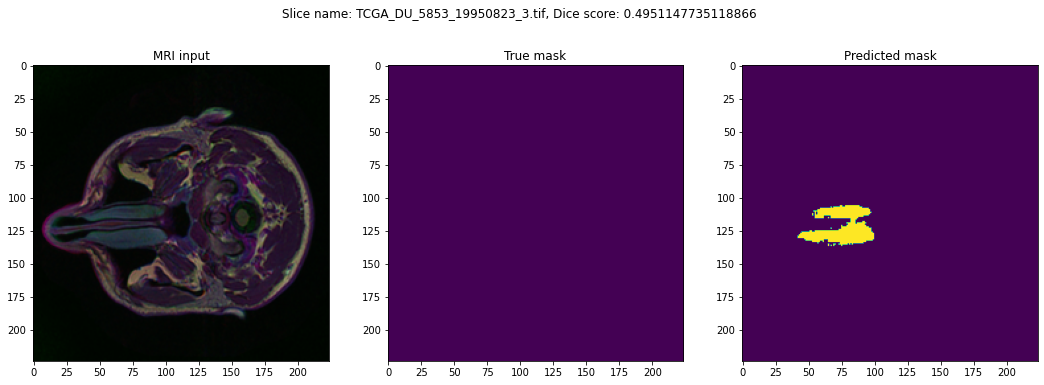

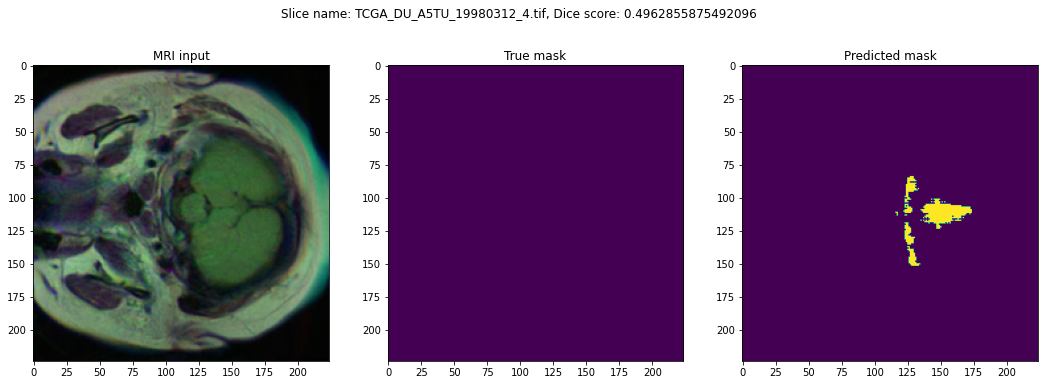

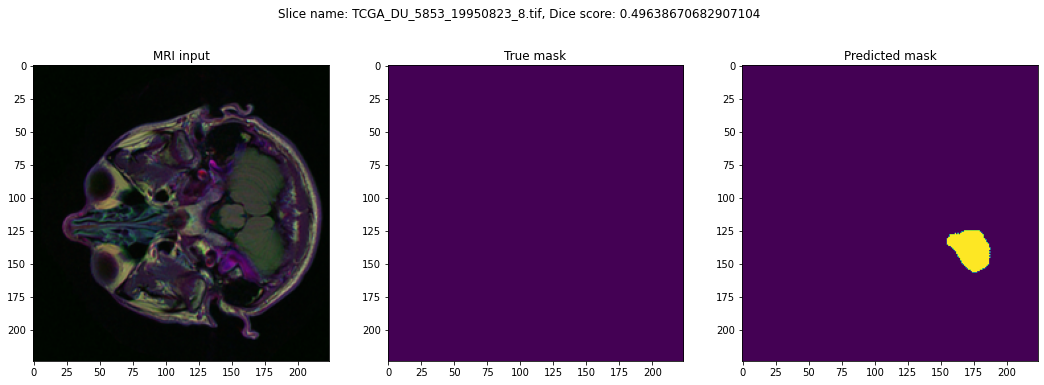

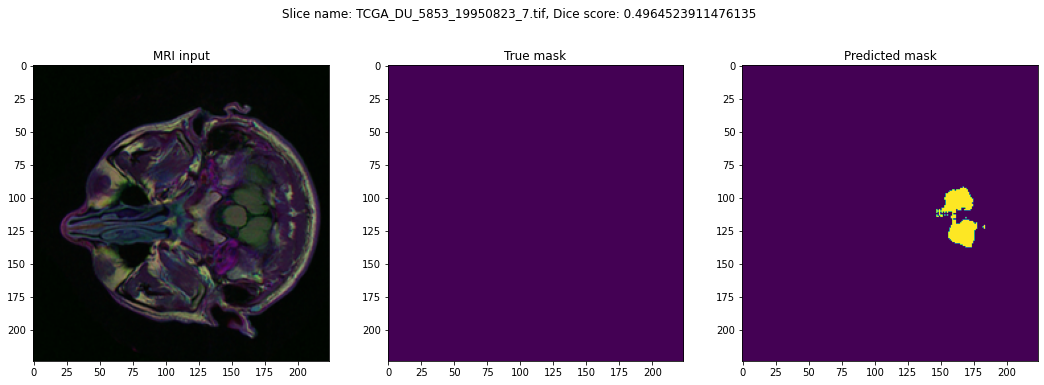

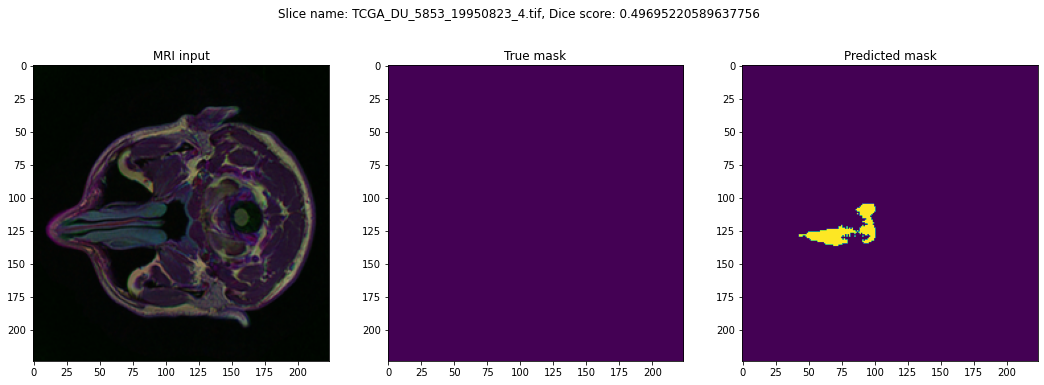

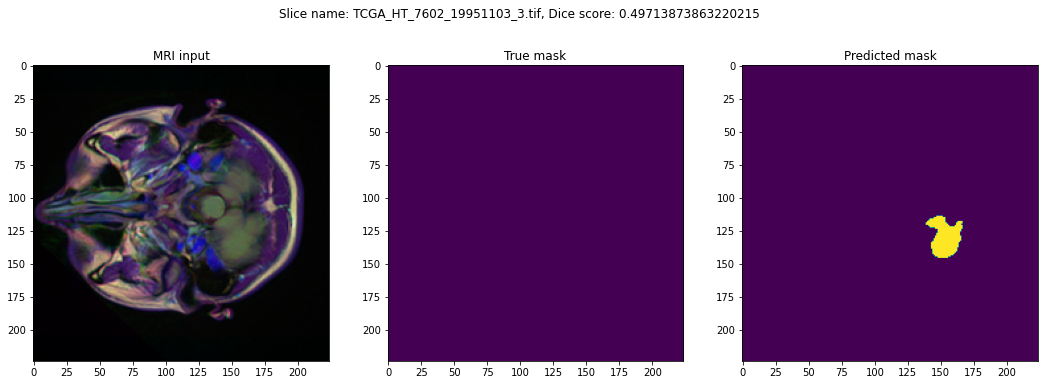

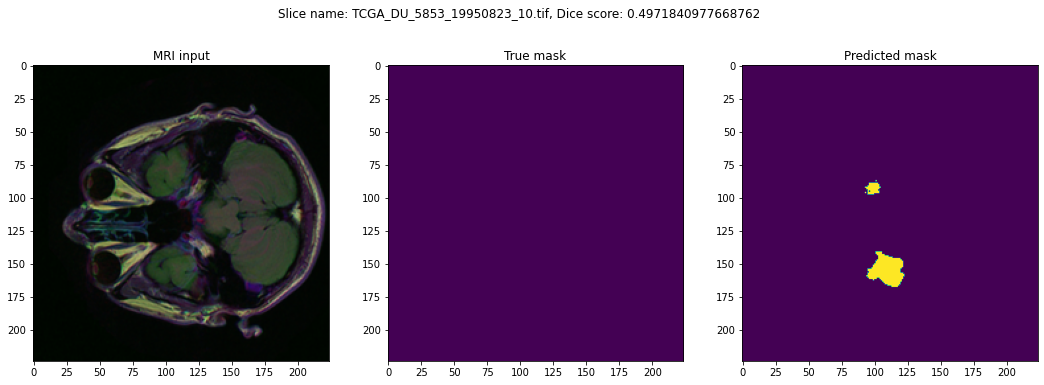

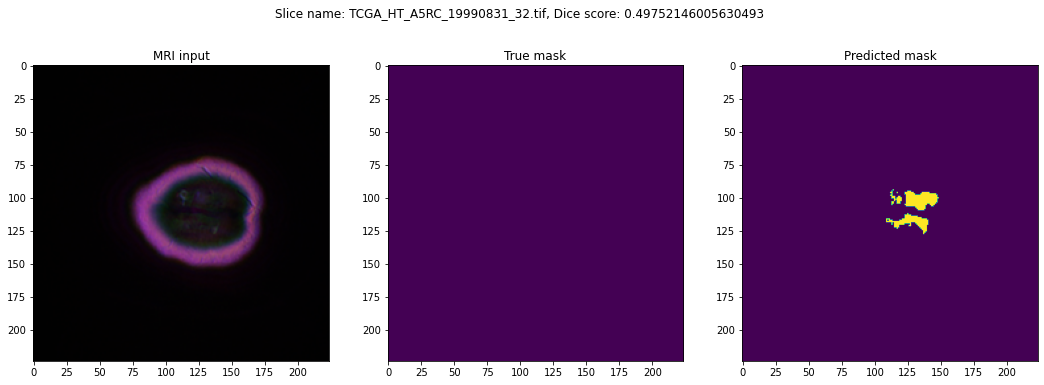

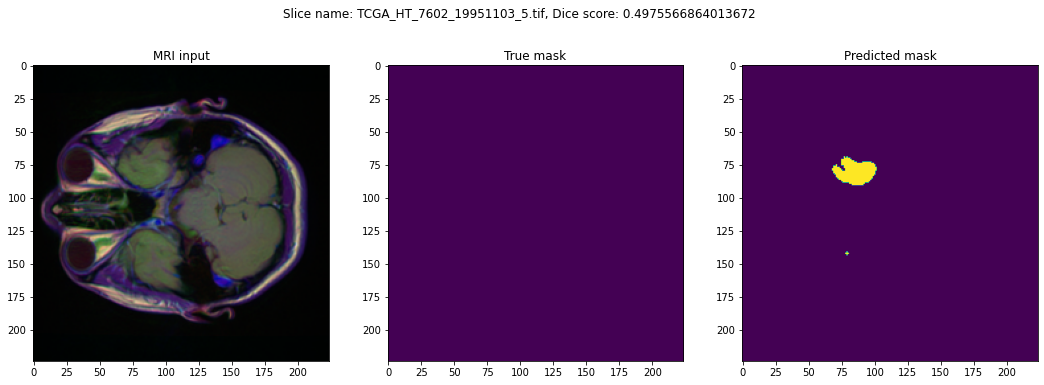

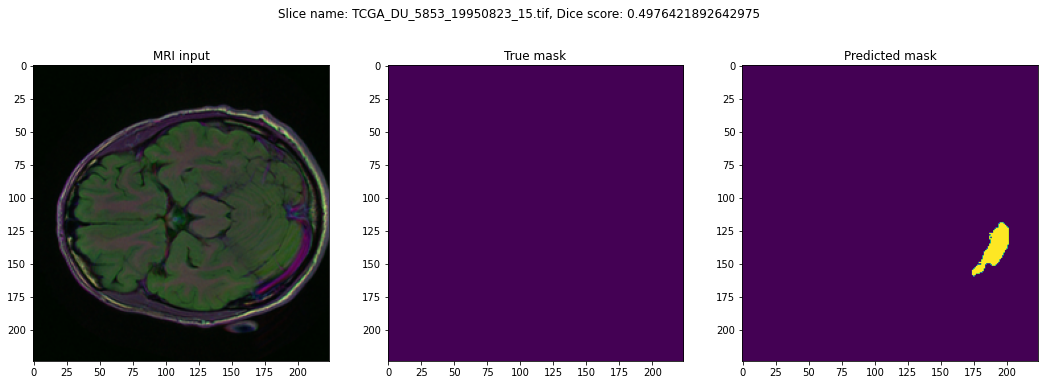

In [150]:
for idx in sorted_idxs[:10]:
    plot_results(idx)

We can see in the examples above that for all these cases the ground truth mask has no positive pixel labels (i.e. no tumour present on these slices). Although it would need to be discussed with radiologists, I guess it is better to have these false positives rather than false negatives. But still, ideally we would want to try to minimize this as far as possible. 

### Plot ten worst which include false negatives
Now let's plot the ten worst results where positive labels exist in the true mask.

In [153]:
plot_idxs = []
for idx in sorted_idxs:
    if mask_all[idx].sum() > 0:
        plot_idxs.append(idx)


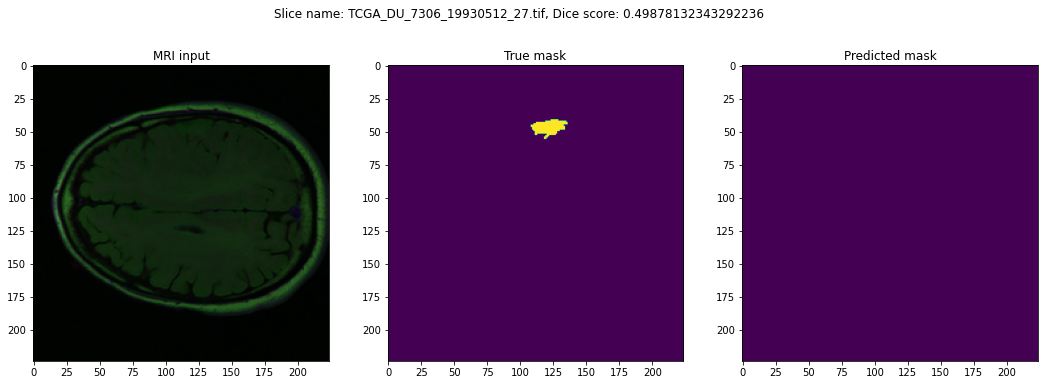

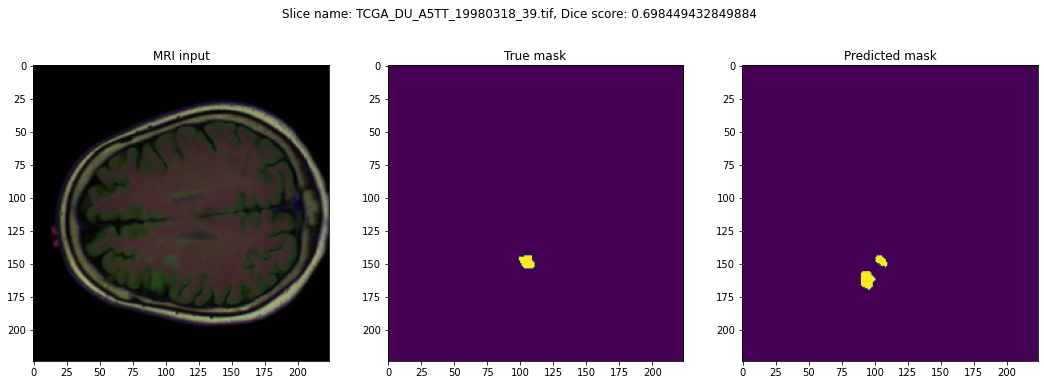

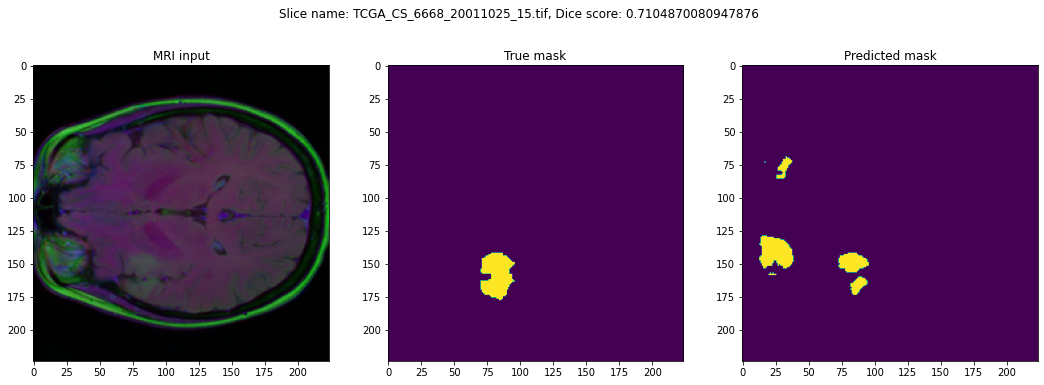

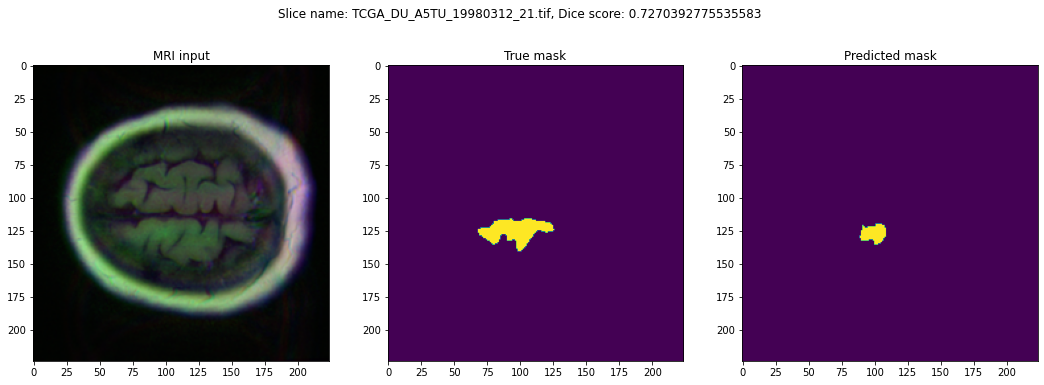

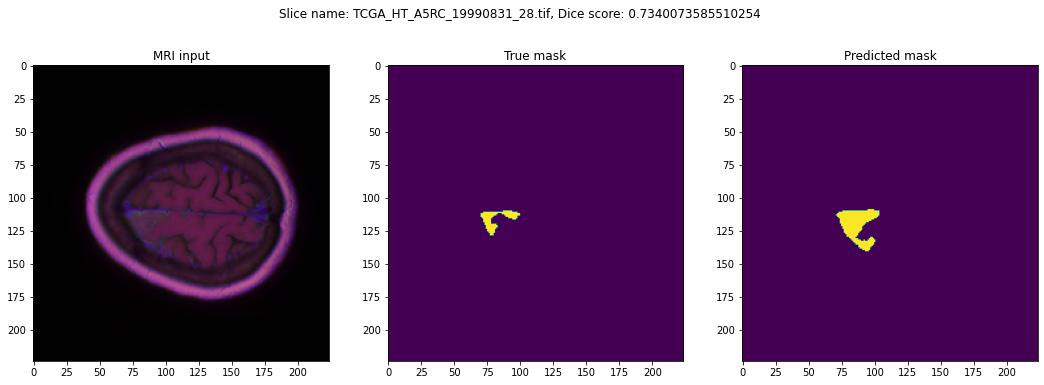

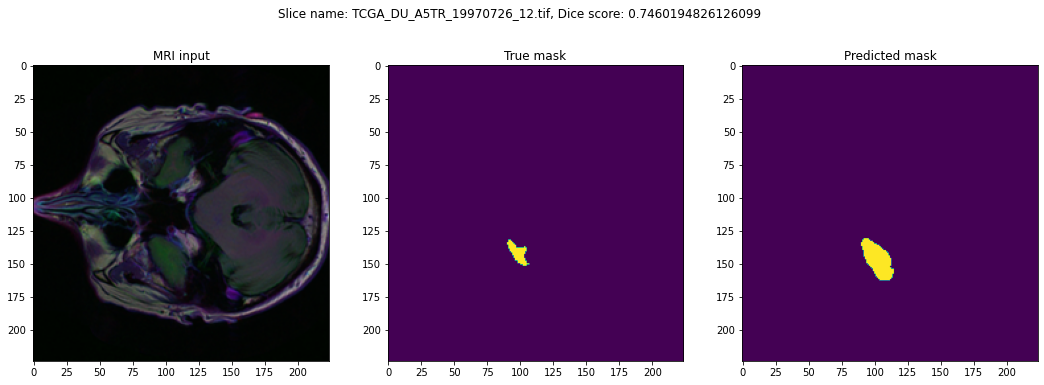

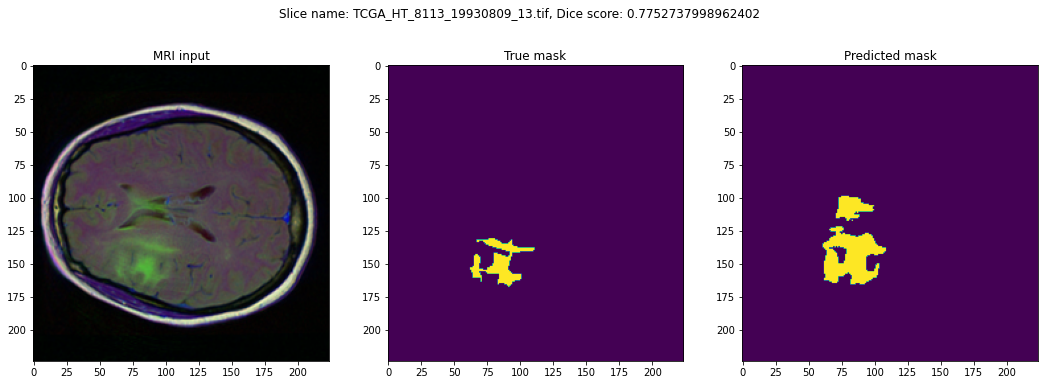

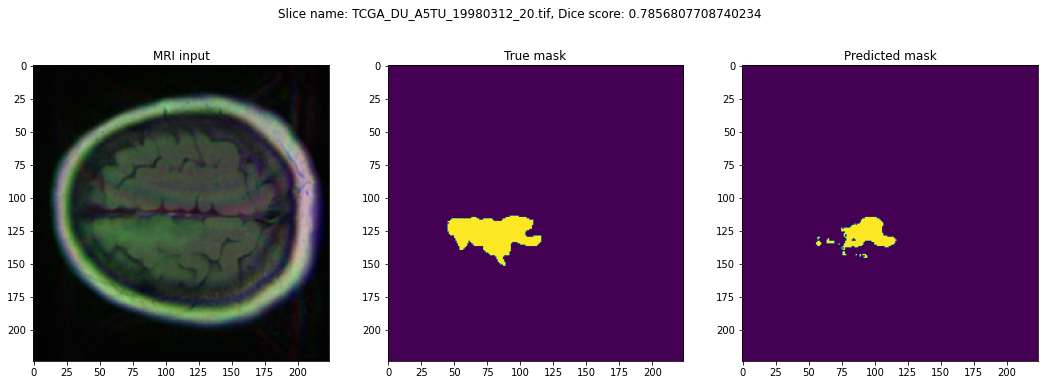

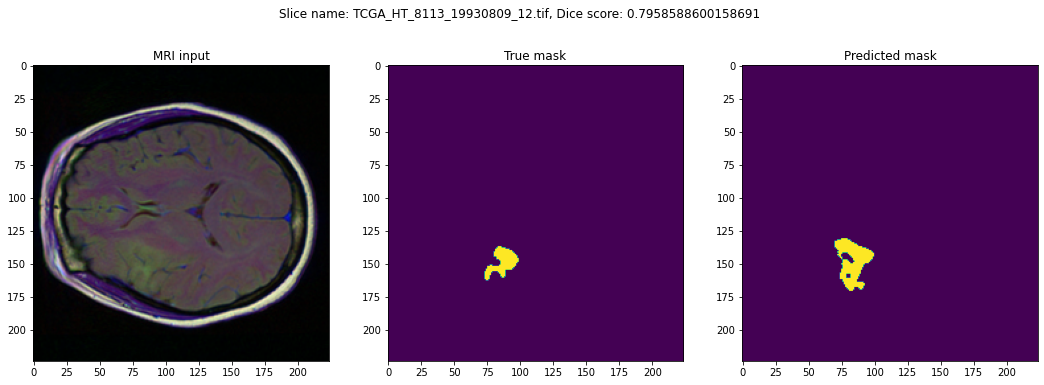

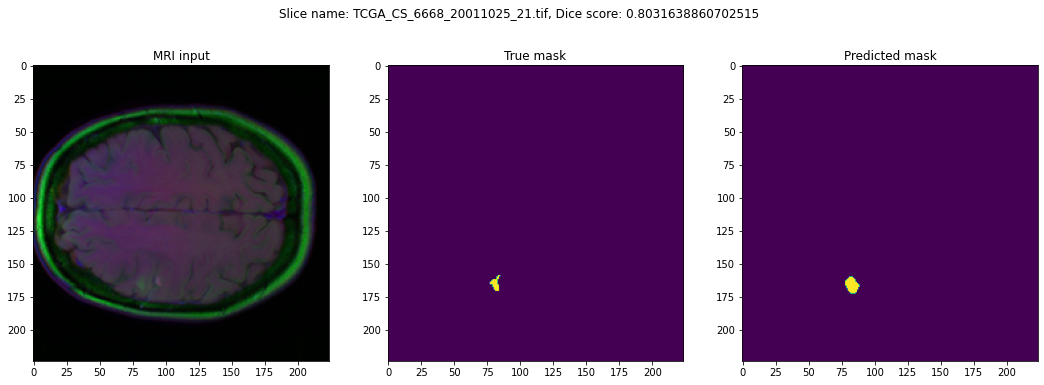

In [156]:
for idx in plot_idxs[:10]:
    plot_results(idx)

We can see that in general these don't look too bad, but we can also see why the model might struggle to get very ccurate results with some of them.

### Ten best predictions with positive labels in ground truth mask
Now let's look at the ten best predicted masks for slices which have positive pixels in the ground truth mask. We can see that these results look quite good, just missing some fine details on the exact shape of the glioma. However, it is these fine details (shape, texture) that may be very important for the medical team in assessing the prognosis and deciding on the best operating proceedure.

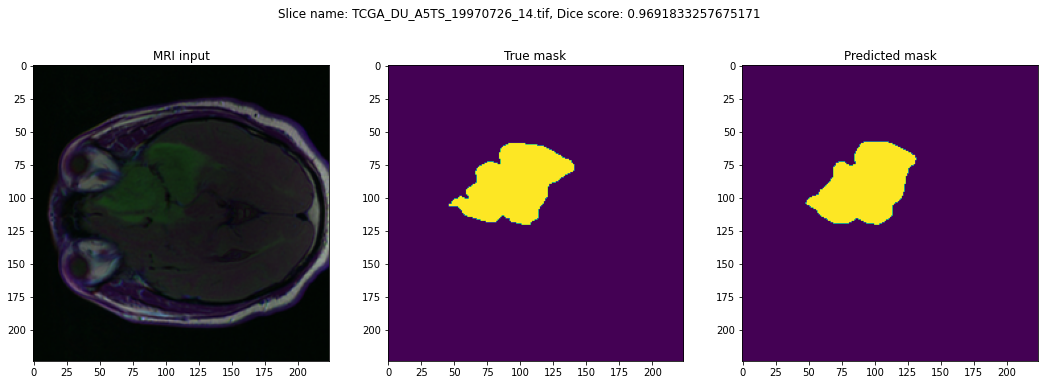

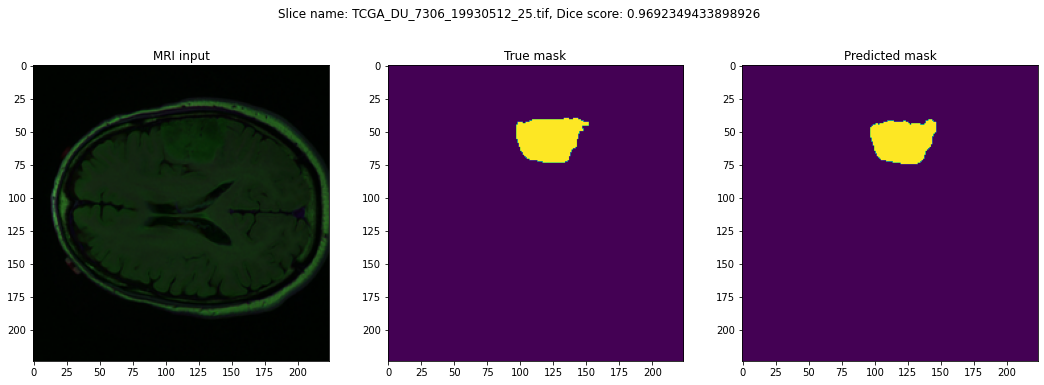

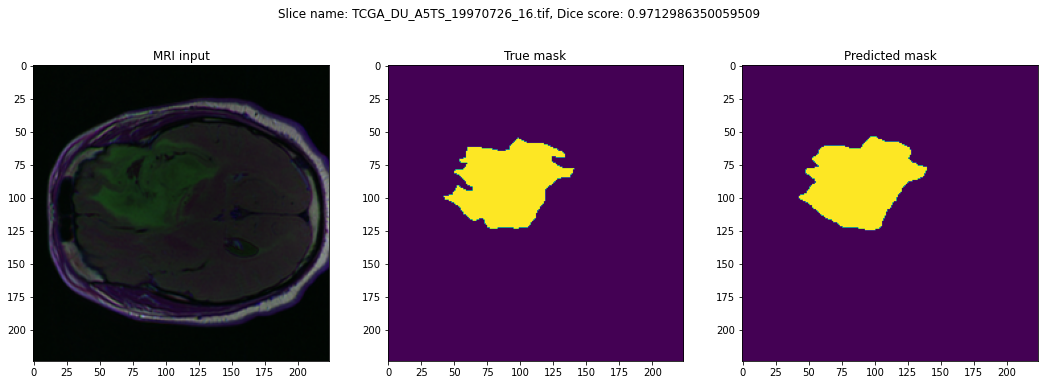

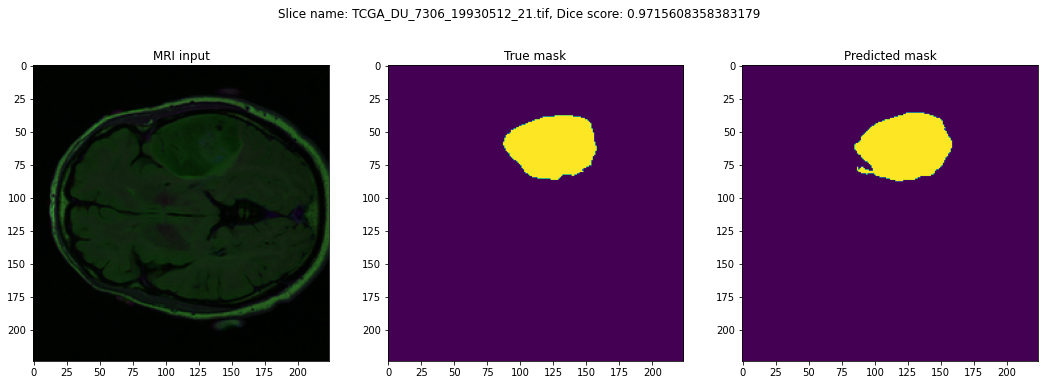

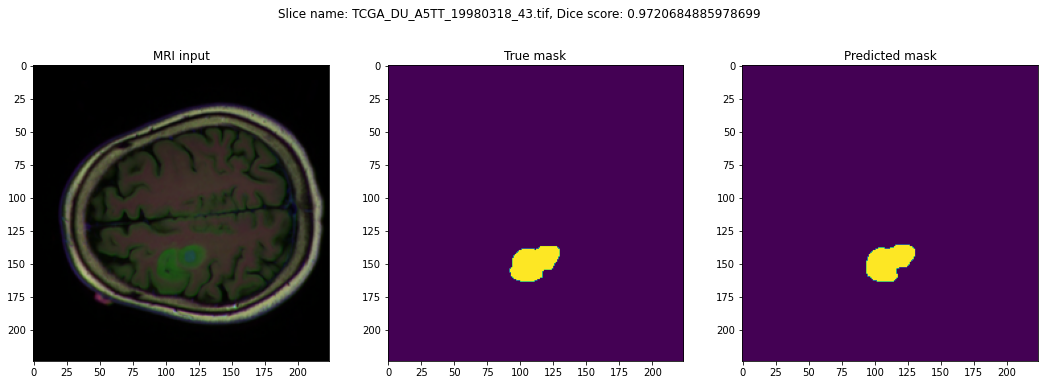

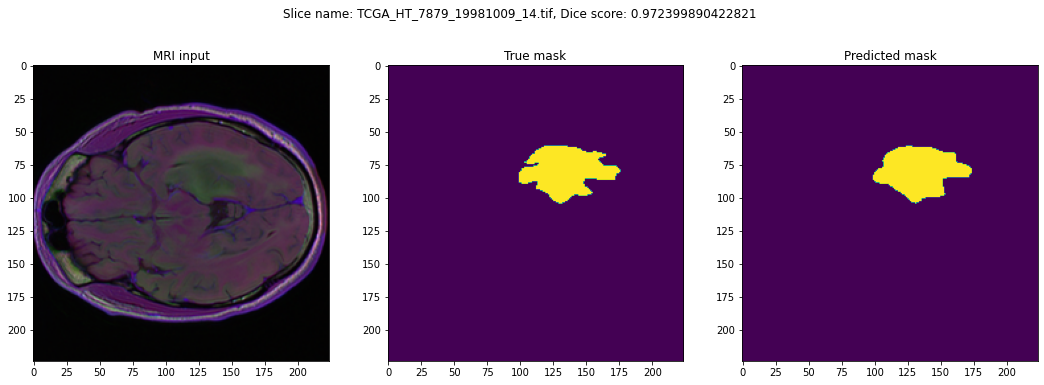

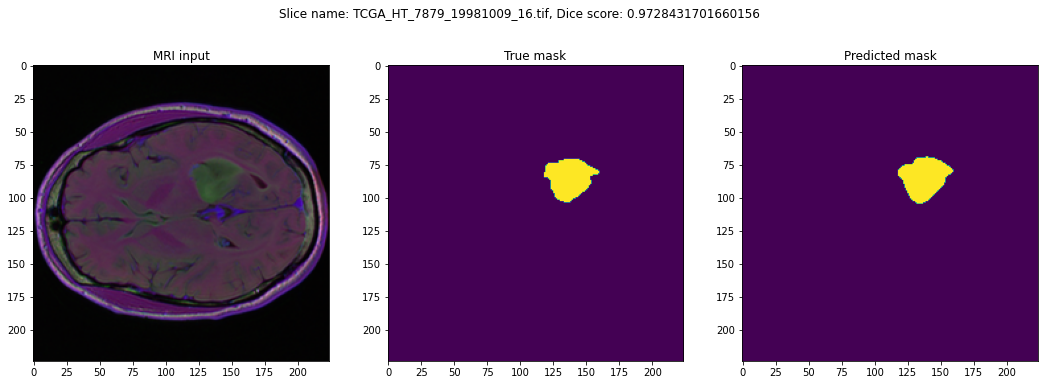

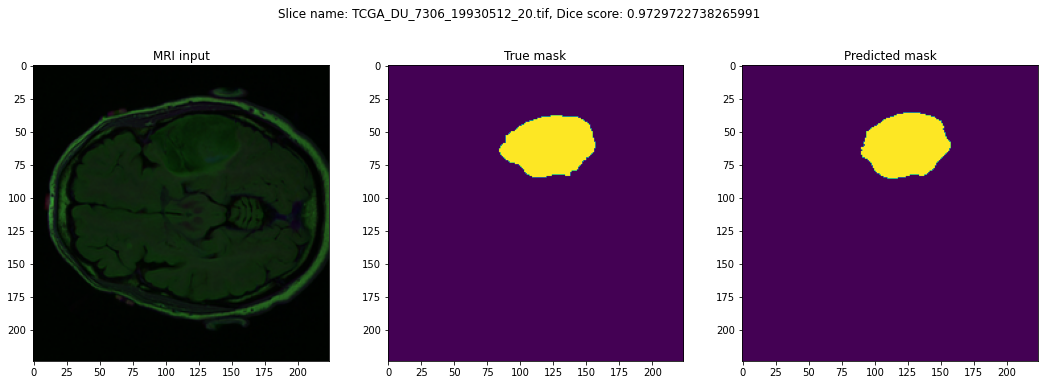

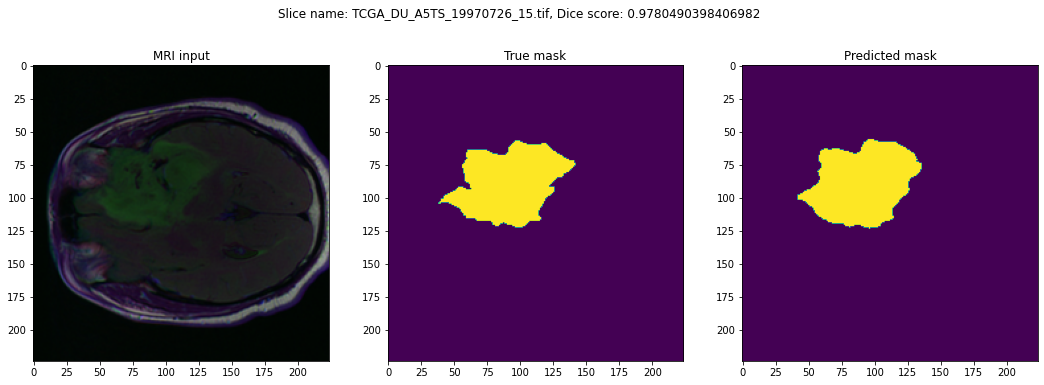

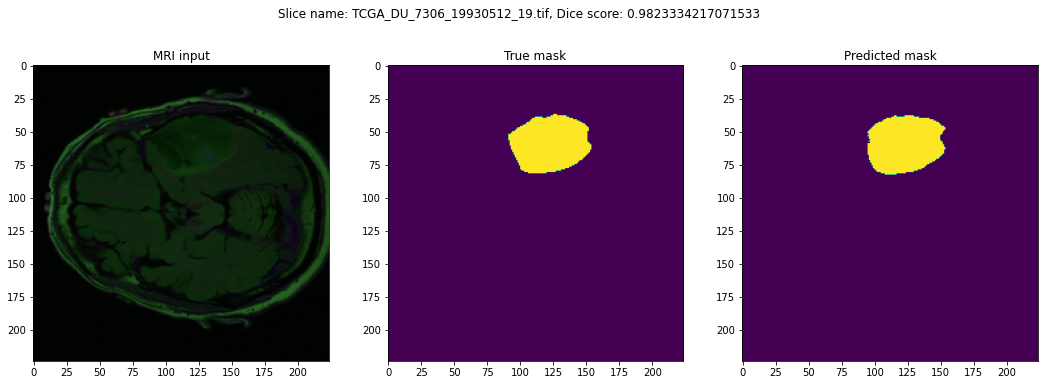

In [158]:
for idx in plot_idxs[-10:]:
    plot_results(idx)

Finally, before finishing make sure to delete the endpoint so that you don't incur unnecessary charges.

In [159]:
predictor.delete_endpoint()

2022-08-19 21:08:06,295 Deleting endpoint configuration with name: pytorch-inference-2022-08-19-15-36-21-732
2022-08-19 21:08:06,643 Deleting endpoint with name: pytorch-inference-2022-08-19-15-36-21-732
